In [11]:
#位相シフタとPDを想定した複素エンコーダ(alpha=0.6)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys

In [13]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data', 'MNIST_AE[5’]_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)

1202
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data\MNIST_AE[5’]_result


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [15]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

In [16]:
#Encoder5
class Encoder(nn.Module):
    def __init__(self,in_features,out_features,alpha=0.6):
        super(Encoder, self).__init__()
        real_part = nn.Parameter(torch.randn(out_features, in_features)*(1/np.sqrt(in_features)))
        imag_part = nn.Parameter(torch.randn(out_features, in_features)*(1/np.sqrt(in_features)))
        self.B = torch.complex(real_part, imag_part).detach()
        self.B.requires_grad = False

        self.alpha = alpha
    
    def forward(self, x):
        print('x',x)
        print('B',self.B)
        x = torch.exp(1j * self.alpha * x) #e^(iαx)
        print('e^(iαx)',x)
        x = x.T
        x = torch.matmul(self.B, x)
        x = torch.abs(x) ** 2
        print('I',x)
        x = x.T
        return x

In [17]:
class Decoder(nn.Module):
    def __init__(self, num_in, num_out):
        super(Decoder, self).__init__()
        self.decoder_fc1 = nn.Linear(num_in, int((num_in+num_out)/2))
        self.a1 = nn.Tanh()
        self.decoder_fc2 = nn.Linear(int((num_in+num_out)/2), num_out)
        self.a2 = nn.Sigmoid()

    def forward(self, x):
        x = self.decoder_fc1(x)
        x = self.a1(x)
        x = self.decoder_fc2(x)
        x = self.a2(x)
        return x

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self,num_N):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(784, num_N)  
        self.decoder = Decoder(num_N, 784)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.encoder(x) 
        
        x_reconstructed = self.decoder(x)
        return x_reconstructed

In [19]:
DofIN = 784 ##
num_N = 10 ##

model = AutoEncoder(num_N)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
loss_train_ = []
loss_test_ = []

max_epochs = 10
for epoch in range(max_epochs):
    loss_train = 0
    loss_test = 0
    for (x,t) in train_dataloader:

        sys.stderr.write('\rEpoch: %d/%d' % (epoch, max_epochs)) 
        sys.stderr.flush()
        
        y = model(x)
        loss = criterion(y, x.view(x.size(0), -1)) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
       
    loss_train_avg = loss_train / len(train_dataloader)

    with torch.no_grad():
        for x, t in test_dataloader:
            y = model(x)
            loss = criterion(y, x.view(x.size(0), -1))
        
            loss_test += loss.item()

    loss_test_avg = loss_test / len(test_dataloader)

    loss_train_.append(loss_train_avg)
    loss_test_.append(loss_test_avg)
    



Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

I tensor([[ 8.5516,  9.4128,  8.3191,  8.5869,  8.0978,  7.6296,  7.9428,  7.9021,
          7.4180,  7.9934,  7.7012,  8.2935,  8.2831,  7.3099,  6.6449,  8.2168,
          7.7534,  8.0391,  7.2830,  8.6208,  8.9505,  8.3718,  7.7941,  7.7857,
          8.4586,  7.9232,  8.5349,  7.9122,  8.5648,  7.9384,  7.0511,  8.2089,
          8.3462,  9.1032,  7.6976,  8.6017,  6.6620, 10.2331,  7.7517,  7.9131,
          8.0423,  8.6172,  7.7010,  7.9198,  8.2750,  7.8224,  6.5929,  9.5623,
          7.7918,  7.7957,  7.7062,  9.1071,  8.6834,  7.2361,  8.3368,  8.6808,
          8.7184,  7.0762,  7.4655,  9.9169,  8.6539,  8.1606,  8.1516,  8.8216,
          9.2765,  7.5195,  8.2023,  8.2350,  8.3140,  8.4962,  9.1776,  8.2114,
          8.6867,  8.6091,  8.2695,  7.5292,  8.0038,  8.3832,  7.4326,  8.4770,
          7.1361,  8.3693,  7.0736,  7.4785,  8.5571,  7.3147,  7.6845,  7.0669,
          7.9950,  8.5189,  7.1292,  8.5594,  8.8185,  8.0695,  6.3633,  6.9613,
          9.6576,  8.1705,

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

Epoch: 0/10

x tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
B tensor([[ 0.0754-0.0741j,  0.0201-0.0161j, -0.0068+0.0524j,  ...,
          0.0010-0.0076j,  0.0259+0.0370j, -0.0370-0.0522j],
        [-0.0301-0.0204j,  0.0780-0.0251j, -0.0274+0.0034j,  ...,
         -0.0395-0.0352j, -0.0010-0.0226j,  0.0548-0.0012j],
        [-0.0367-0.0591j, -0.0478-0.0147j, -0.0231-0.0209j,  ...,
          0.0491-0.0325j,  0.0151+0.0062j,  0.0521+0.0091j],
        ...,
        [ 0.0266-0.0052j, -0.0520+0.0803j, -0.0048+0.0123j,  ...,
         -0.0004-0.0107j, -0.0351+0.0136j,  0.0155+0.0215j],
        [ 0.0162-0.0263j,  0.0016-0.0141j, -0.0849+0.0732j,  ...,
          0.0332+0.0027j,  0.0347+0.0302j, -0.0718-0.0324j],
        [-0.0284+0.0317j, -0.0627-0.0175j,  0.0340-0.0004j,  ...,
          0.0203-0.0301j,  0

KeyboardInterrupt: 

In [ ]:
All_loss_train_avg = sum(loss_train_)/len(loss_train_)
All_loss_test_avg = sum(loss_test_)/len(loss_test_)

Last_loss_train = loss_train_[-1]
Last_loss_test = loss_test_[-1]

print('Train MSE AVG:  ',All_loss_train_avg)
print('Test MSE AVG:   ',All_loss_test_avg)

print('Train Last MSE: ',Last_loss_train)
print('Test Last MSE:  ',Last_loss_test)

Train MSE AVG:   0.012109673795678342
Test MSE AVG:    0.00967969925655052
Train Last MSE:  0.006698943917484333
Test Last MSE:   0.006424007890745998


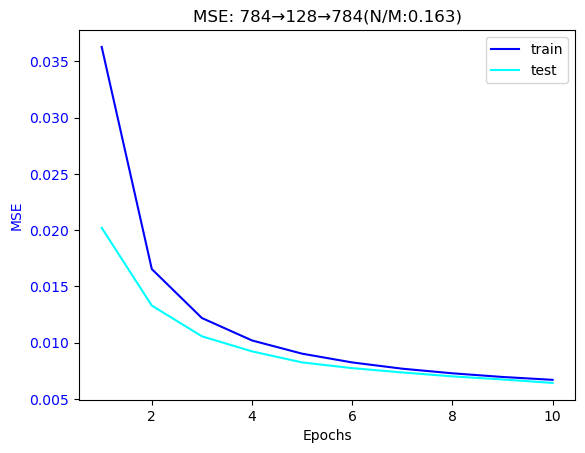

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d→%d→%d(N/M:%.3f)'%(DofIN,num_N,DofIN,num_N/DofIN) ##
plt.title(title)
plt.legend()
file_name = '%d_LOSS%d→%d→%d.png'%(int(formatted_date),DofIN,num_N,DofIN)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

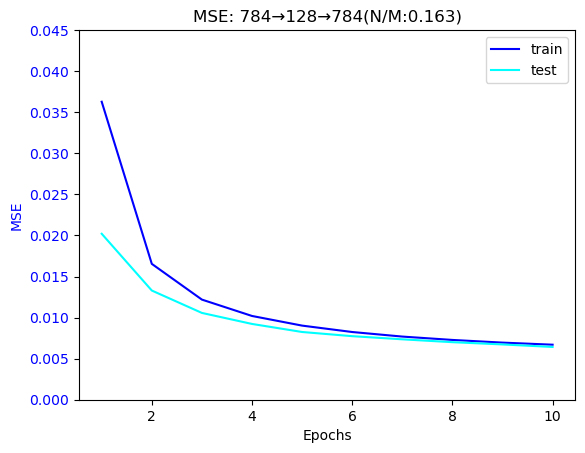

In [ ]:
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.ylim(0,0.045)
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d→%d→%d(N/M:%.3f)'%(DofIN,num_N,DofIN,num_N/DofIN) ##
plt.title(title)
plt.legend()
file_name = '%d_LOSS%d→%d→%d_ex.png'%(int(formatted_date),DofIN,num_N,DofIN)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

In [ ]:
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] 
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

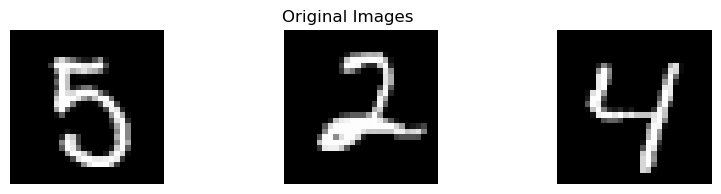

In [ ]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:
        break
show_images(test_images, test_labels,"Original Images")

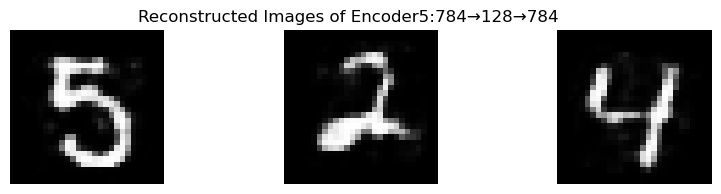

In [ ]:
with torch.no_grad():
    reconstructed_images = model(test_images)
    show_images(reconstructed_images,test_labels, "Reconstructed Images of Encoder5:%d→%d→%d"%(DofIN,num_N,DofIN))
    file_name = '%d_ReImage%d→%d→%d.png'%(int(formatted_date),DofIN,num_N,DofIN)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

In [ ]:
import csv
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data','texts') 
print(save_directory)
os.makedirs(save_directory, exist_ok=True)
file_name = 'AE[5_]_lis.csv'##
full_path = os.path.join(save_directory, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(loss_test_)

/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data/texts
